# Connect to Google Drive (exploration)

This notebook shows how to authenticate and interact with a Google Drive folder (list images, sample-download a few) without downloading the full dataset. You can reuse these helpers later in scripts.

Prerequisites:
- Create an OAuth 2.0 Client (Desktop) in Google Cloud Console.
- Download the JSON and place it at `secrets/client_secrets.json` (or set `GOOGLE_OAUTH_CLIENT_SECRETS`).
- First run will open a browser for consent; tokens are cached locally for reuse.

Notes:
- Supports Shared Drives if your data is there (set `INCLUDE_SHARED_DRIVES=True`).
- Use `TEST_MODE=True` to limit the number of files listed/processed.


In [ ]:
#%pip install -q pydrive2 google-auth-oauthlib tqdm pillow


In [ ]:
#%pip install -q python-dotenv


Note: you may need to restart the kernel to use updated packages.


In [10]:
# Load environment variables from .env if present
import os
from pathlib import Path
from typing import Optional

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from dotenv import load_dotenv

# Load environment variables from .env (project root and current dir)
from dotenv import load_dotenv

def find_project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for candidate in [p, *p.parents]:
        if (candidate / '.git').exists() or (candidate / 'requirements.txt').exists():
            return candidate
    return p

PROJECT_ROOT = find_project_root()
load_dotenv(dotenv_path=PROJECT_ROOT / '.env', override=False)
load_dotenv(dotenv_path=Path('.env'), override=False)

# Provide sensible defaults if env vars are not set
os.environ.setdefault(
    'GOOGLE_OAUTH_CLIENT_SECRETS', str((PROJECT_ROOT / 'secrets/client_secrets.json').resolve())
)
os.environ.setdefault(
    'GOOGLE_OAUTH_CREDENTIALS_CACHE', str((PROJECT_ROOT / 'secrets/credentials.json').resolve())
)
print(f"Loaded .env (if present). PROJECT_ROOT={PROJECT_ROOT}")



Loaded .env (if present). PROJECT_ROOT=/Users/starsrain/2025_codeProject/GreenSpace_CNN


In [11]:
def authenticate(use_local_server: bool = True, client_secrets_path: Optional[str] = None) -> GoogleDrive:
    """Authenticate to Google Drive and return a GoogleDrive client.
    Credentials sourcing (in order):
    1) explicit client_secrets_path arg
    2) env GOOGLE_OAUTH_CLIENT_SECRETS (path to client_secrets.json)
    3) default secrets/client_secrets.json

    Access/refresh tokens are cached at GOOGLE_OAUTH_CREDENTIALS_CACHE or defaults to secrets/credentials.json.
    """
    client_secrets = (
        client_secrets_path
        or os.environ.get("GOOGLE_OAUTH_CLIENT_SECRETS")
        or str(Path("secrets/client_secrets.json").resolve())
    )
    cred_cache = (
        os.environ.get("GOOGLE_OAUTH_CREDENTIALS_CACHE")
        or str(Path("secrets/credentials.json").resolve())
    )

    gauth = GoogleAuth()
    gauth.LoadClientConfigFile(client_secrets)
    gauth.settings['get_refresh_token'] = True  
    # Try to use cached credentials if available
    try:
        if Path(cred_cache).exists():
            gauth.LoadCredentialsFile(cred_cache)
    except Exception:
        pass
      
    if not getattr(gauth, "credentials", None):
        if use_local_server:
            gauth.LocalWebserverAuth()
        else:
            gauth.CommandLineAuth()
    elif getattr(gauth, "access_token_expired", False):
        gauth.Refresh()
    else:
        gauth.Authorize()

    # Persist credentials for future runs
    try:
        Path(cred_cache).parent.mkdir(parents=True, exist_ok=True)
        gauth.SaveCredentialsFile(cred_cache)
    except Exception:
        pass

    drive = GoogleDrive(gauth)
    return drive


In [12]:
from typing import Iterable, List, Dict, Optional


def list_files_in_folder(
    drive: GoogleDrive,
    folder_id: str,
    *,
    mime_prefix: Optional[str] = None,
    limit: Optional[int] = None,
    include_trashed: bool = False,
    include_shared_drives: bool = True,
    drive_id: Optional[str] = None,
) -> List[Dict]:
    """List files in a Drive folder. Optionally filter by MIME prefix (e.g., 'image/').
    For Shared Drives, set include_shared_drives=True and optionally provide drive_id.
    """
    q = [f"'{folder_id}' in parents"]
    if not include_trashed:
        q.append("trashed = false")
    if mime_prefix:
        q.append(f"mimeType contains '{mime_prefix}'")
    query = " and ".join(q)

    params = {
        "q": query,
        "supportsAllDrives": include_shared_drives,
        "includeItemsFromAllDrives": include_shared_drives,
        # For shared drives, uncomment the next two lines and set driveId
        # "corpora": "drive" if drive_id else "user",
        # "driveId": drive_id,
    }

    file_list = drive.ListFile(params).GetList()
    if limit is not None:
        file_list = file_list[: int(limit)]

    # Normalize output (id, title/name, mimeType, size if present)
    out = []
    for f in file_list:
        out.append({
            "id": f["id"],
            "name": f.get("title") or f.get("name"),
            "mimeType": f.get("mimeType"),
            "size": int(f.get("fileSize", 0)) if f.get("fileSize") else None,
        })
    return out


def download_file_bytes(drive: GoogleDrive, file_id: str) -> bytes:
    """Download a Drive file to memory and return its raw bytes."""
    f = drive.CreateFile({"id": file_id})
    # Load content into memory (BytesIO) and return as bytes
    f.FetchContent()
    return f.content.getvalue()


In [13]:
# --- Configuration ---
FOLDER_ID = os.getenv("GOOGLE_DRIVE_FOLDER_ID", "REPLACE_WITH_DRIVE_FOLDER_ID")  # e.g., '1AbC...'
INCLUDE_SHARED_DRIVES = os.getenv("GOOGLE_DRIVE_INCLUDE_SHARED", "true").lower() in {"1","true","yes","y"}
TEST_MODE = os.getenv("TEST_MODE", "true").lower() in {"1","true","yes","y"}
TEST_LIMIT = int(os.getenv("TEST_LIMIT", "25"))  # Only list/process first N files when TEST_MODE is True
MIME_PREFIX = os.getenv("GOOGLE_DRIVE_MIME_PREFIX", "image/")  # set None to list all

# Authenticate and create a Drive client
drive = authenticate(use_local_server=True)
print("Authenticated to Google Drive.")


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=917609042126-kkdo31j7cc0m5hhvrst3urng2gkloc21.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code&approval_prompt=force

Authentication successful.
Authenticated to Google Drive.


In [14]:
# List files in the Drive folder (respects TEST_MODE)
limit = TEST_LIMIT if TEST_MODE else None
files = list_files_in_folder(
    drive,
    FOLDER_ID,
    mime_prefix=MIME_PREFIX,
    limit=limit,
    include_shared_drives=INCLUDE_SHARED_DRIVES,
)

print(f"Found {len(files)} files (showing up to {limit or 'all'}):")
for i, f in enumerate(files[:10]):
    print(f"{i:02d} | {f['name']} | {f['id']} | {f['mimeType']}")


Found 25 files (showing up to 25):
00 | USA_2238145-0001_1_1-00000_f01_p000.jpg | 1vBpKSwC5nq-grJrxlGyI1v1aA7loPyS_ | image/jpeg
01 | USA_56602-0183_1_27-00000_f20_p000.jpg | 13HiHVVZBWN9aWlvqDopkfAW4hPgRrrZ9 | image/jpeg
02 | USA_2954074-0008_1_10-00000_f02_p000.jpg | 1Nxk3mgOXBfxuJQ3WEiYPrnURW7SKHrFF | image/jpeg
03 | USA_71317-0205_1_0-00000_f00_p000.jpg | 1-ppDZnNmVA6PbshjXvgNwR-SqyDtMe6U | image/jpeg
04 | USA_71317-0213_1_0-00000_f00_p000.jpg | 10eD0ulTBRdbq_0xUa-vmsHaUBD4r2S0w | image/jpeg
05 | USA_71317-0205_1_4-00000_f04_p000.jpg | 1jjoHMkDwPgRB4VojLw5aqxuuQFMOI2As | image/jpeg
06 | USA_71317-0205_1_1-00000_f01_p000.jpg | 16nrDbRwkPEt8nJ6Ddw9Pa3A3YJ9dF4o4 | image/jpeg
07 | USA_71317-0205_1_5-00000_f05_p000.jpg | 1W1V59nEx71dQrBWTq71JzSCHrOv-_QWL | image/jpeg
08 | USA_71317-0205_1_2-00000_f02_p000.jpg | 1H3pX_V6yxgO5aLinTMhU8bM9nhecFz0h | image/jpeg
09 | USA_71317-0198_1_0-00000_f00_p000.jpg | 1GGLOjJObz5Rqet1ERBSlp53rgnFvd6PF | image/jpeg


In [14]:
# See how many files are in the folder
# Count total files in the Drive folder (ignores TEST_MODE)
all_files = list_files_in_folder(
    drive,
    FOLDER_ID,
    mime_prefix=MIME_PREFIX,  # set to None to count all types
    limit=None,
    include_shared_drives=INCLUDE_SHARED_DRIVES,
)
print(f"Total files in folder (mime filter={MIME_PREFIX!r}): {len(all_files)}")


Total files in folder (mime filter='image/'): 29161


In [15]:
# Check one image's format (size, mode) without saving to disk
from io import BytesIO
from PIL import Image
import numpy as np

if not files:
    raise RuntimeError("No files returned. Verify GOOGLE_DRIVE_FOLDER_ID and permissions.")

sample = files[0]
raw = download_file_bytes(drive, sample["id"])  # bytes in memory
img = Image.open(BytesIO(raw))

print(f"Name: {sample.get('name')}")
print(f"PIL mode: {img.mode}")
print(f"Size (W,H): {img.size}")
print(f"Format: {getattr(img, 'format', None)}")

arr = np.array(img)
print(f"Array shape: {arr.shape}, dtype: {arr.dtype}, min: {arr.min()}, max: {arr.max()}")

print(f"Is 512x512? {img.size == (512, 512)}")
print(f"Is RGB? {img.mode == 'RGB'}")


Name: USA_2238145-0001_1_1-00000_f01_p000.jpg
PIL mode: RGB
Size (W,H): (512, 512)
Format: JPEG
Array shape: (512, 512, 3), dtype: uint8, min: 0, max: 210
Is 512x512? True
Is RGB? True


Previewing: USA_2238145-0001_1_1-00000_f01_p000.jpg (86.8 KB)


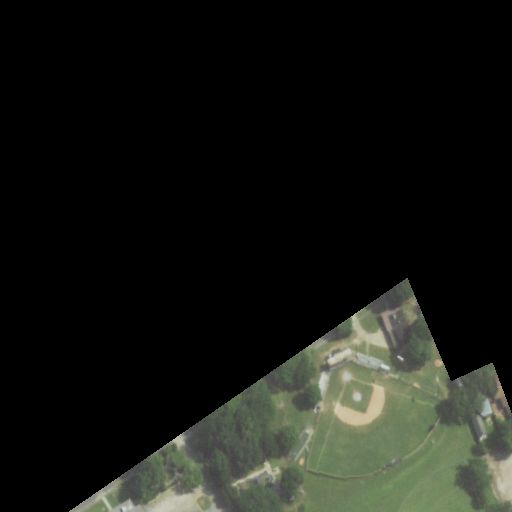

In [16]:
# Download one sample image to memory and preview
from io import BytesIO
from PIL import Image
from IPython.display import display

if files:
    sample = files[0]
    raw = download_file_bytes(drive, sample["id"])
    img = Image.open(BytesIO(raw)).convert("RGB")
    print(f"Previewing: {sample['name']} ({len(raw)/1024:.1f} KB)")
    display(img)
else:
    print("No files returned. Check FOLDER_ID and permissions.")
